In [1]:
from pyspark.sql import SparkSession
import os
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
import scipy.stats as stats
from sklearn.cluster import KMeans
import seaborn as sns
import numpy as np


In [2]:

lista_arquivo = ['ativos/'+ arquivo for arquivo in os.listdir('ativos')]

In [3]:
print(lista_arquivo)

['ativos/AALR3', 'ativos/ABCB4', 'ativos/ABEV3', 'ativos/ADHM3', 'ativos/AERI3', 'ativos/AESB3', 'ativos/AFLT3', 'ativos/AGRO3', 'ativos/AGXY3', 'ativos/AHEB3', 'ativos/AHEB5', 'ativos/AHEB6', 'ativos/ALLD3', 'ativos/ALPA3', 'ativos/ALPA4', 'ativos/ALPK3', 'ativos/ALSC3', 'ativos/ALSO3', 'ativos/ALUP11', 'ativos/ALUP3', 'ativos/ALUP4', 'ativos/AMAR3', 'ativos/AMBP3', 'ativos/AMER3', 'ativos/ANDG3B', 'ativos/ANDG4B', 'ativos/ANIM3', 'ativos/APER3', 'ativos/APTI3', 'ativos/APTI4', 'ativos/ARML3', 'ativos/ARZZ3', 'ativos/ASAI3', 'ativos/ATMP3', 'ativos/ATOM3', 'ativos/AURA33', 'ativos/AURE3', 'ativos/AVLL3', 'ativos/AZEV3', 'ativos/AZEV4', 'ativos/AZUL4', 'ativos/B3SA3', 'ativos/BAHI3', 'ativos/BALM3', 'ativos/BALM4', 'ativos/BAUH4', 'ativos/BAZA3', 'ativos/BBAS3', 'ativos/BBDC3', 'ativos/BBDC4', 'ativos/BBML3', 'ativos/BBSE3', 'ativos/BDLL3', 'ativos/BDLL4', 'ativos/BEEF11', 'ativos/BEEF3', 'ativos/BEES3', 'ativos/BEES4', 'ativos/BFRE11', 'ativos/BFRE12', 'ativos/BGIP3', 'ativos/BGIP4', 

In [5]:
spark = SparkSession.builder.appName("leitura").getOrCreate()


In [6]:

df = spark.read.option("multiline", "true").json(lista_arquivo)

In [7]:
df.show()

+-----+--------------+--------------------+-------+-----+
|ativo|indicator_name|                nome|  value| year|
+-----+--------------+--------------------+-------+-----+
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|     -%|ATUAL|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|     -%| 2022|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|     -%| 2021|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|  0,79%| 2020|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|  0,47%| 2019|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|     -%| 2018|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|     -%| 2017|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|     -%| 2016|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|     -%| 2015|
|AALR3|           D.Y|ALLIANÇA SAÚDE E ...|     -%| 2014|
|AALR3|           P/L|ALLIANÇA SAÚDE E ...| -11,55|ATUAL|
|AALR3|           P/L|ALLIANÇA SAÚDE E ...| -11,22| 2022|
|AALR3|           P/L|ALLIANÇA SAÚDE E ...|-314,82| 2021|
|AALR3|           P/L|ALLIANÇA SAÚDE E ...| -13,48| 2020|
|AALR3|       

In [8]:
df_atual = (df.filter(df['year']=='2022')
            .withColumn('indicator_name',regexp_replace(col('indicator_name'),'\.','')))

In [9]:
df_pivot = df_atual.groupBy(df_atual['ativo'],df_atual['year'],df_atual['nome']).pivot('indicator_name').agg(expr('first(value)'))

In [10]:
df_pivot.printSchema()

root
 |-- ativo: string (nullable = true)
 |-- year: string (nullable = true)
 |-- nome: string (nullable = true)
 |-- CAGR LUCROS 5 ANOS: string (nullable = true)
 |-- CAGR RECEITAS 5 ANOS: string (nullable = true)
 |-- DY: string (nullable = true)
 |-- DÍV LÍQUIDA/EBIT: string (nullable = true)
 |-- DÍV LÍQUIDA/EBITDA: string (nullable = true)
 |-- DÍV LÍQUIDA/PL: string (nullable = true)
 |-- EV/EBIT: string (nullable = true)
 |-- EV/EBITDA: string (nullable = true)
 |-- GIRO ATIVOS: string (nullable = true)
 |-- LIQ CORRENTE: string (nullable = true)
 |-- LPA: string (nullable = true)
 |-- M BRUTA: string (nullable = true)
 |-- M EBIT: string (nullable = true)
 |-- M EBITDA: string (nullable = true)
 |-- M LÍQUIDA: string (nullable = true)
 |-- P/ATIVO: string (nullable = true)
 |-- P/ATIVO CIRC LIQ: string (nullable = true)
 |-- P/CAP GIRO: string (nullable = true)
 |-- P/EBIT: string (nullable = true)
 |-- P/EBITDA: string (nullable = true)
 |-- P/L: string (nullable = true)
 |--

In [11]:
etl_columns = df_pivot.columns[-30:]
for column in etl_columns:
    df_pivot = df_pivot.withColumn(column, regexp_replace(col(column),',','.'))
    df_pivot = df_pivot.withColumn(column, regexp_replace(col(column),'%',''))
    df_pivot = df_pivot.withColumn(column,col(column).cast("float"))
    df_pivot = df_pivot.fillna(0,subset=[column])
    df_pivot = df_pivot.withColumn(column,round(col(column),2))


Cenrio - 1 Analise com a todas as colunas da tabela filtrando a ano 2022

In [168]:
df_indicadores = df_pivot.select('ativo','year','DY','P/L','EV/EBITDA','M EBITDA', 'ROE', 'P/VP','VPA')

In [169]:
df_indicadores.count()

620

In [ ]:
for coluna in df_base.columns:
    df_base[coluna] = stats.zscore(df_base[coluna])

In [170]:
deletar=['ativo','year']
df_base = df_indicadores.drop(*deletar)

In [79]:
etl_columns = df_indicadores.columns[-7:]
iqr_multi = 1.5
for coluna in etl_columns:
    quantiles = df_indicadores.approxQuantile(coluna,[0.10,0.90],0)
    q1 = quantiles[0]
    q3 = quantiles[1]
    iqr = q3-q1

In [80]:
lower_limit = q1 -(iqr_multi*iqr)
upper_limit = q3 + (iqr_multi*iqr)

In [81]:
df_out_out = df_indicadores.filter((col(coluna) >=lower_limit) & (col(coluna)<= upper_limit))

In [82]:
df_out_out.count()

585

In [65]:
verifica = df_indicadores.join(df_out_out, on ='ativo',how='left_anti')#.filter(df_out_out.ativo.isNull())

In [66]:
verifica.show()

+------+----+-----+-----+---------+--------+-----+-----+-------+
| ativo|year|   DY|  P/L|EV/EBITDA|M EBITDA|  ROE| P/VP|    VPA|
+------+----+-----+-----+---------+--------+-----+-----+-------+
| BAZA3|2022|13.75| 2.49|      0.0|    2.49|13.75| 0.58|  86.36|
| BDLL3|2022|  0.0| 0.29|    -8.53|    0.29|  0.0|-0.17|  -69.2|
| BDLL4|2022|  0.0| 0.19|    -8.53|    0.19|  0.0|-0.12|  -69.2|
| BMKS3|2022| 5.66| 5.47|    -2.33|    5.47| 5.66| 0.71| 447.39|
| BNBR3|2022| 5.89| 3.21|      0.0|    3.21| 5.89| 0.72| 104.16|
| BPAR3|2022| 5.69| 7.28|      0.0|    7.28| 5.69| 1.02| 178.47|
|BPAT33|2022|  0.0| 6.98|      0.0|    6.98|  0.0| 0.66|  66.71|
| CCXC3|2022|  0.0| -0.1|      0.0|    -0.1|  0.0|-0.03| -45.41|
| CEED3|2022|  0.0|-9.74|    11.86|   -9.74|  0.0|-0.95| -40.21|
| CEED4|2022|  0.0|-8.98|    11.86|   -8.98|  0.0|-0.87| -40.21|
| CLSC3|2022| 9.09| 3.67|      0.0|    3.67| 9.09| 0.69|  74.75|
| CLSC4|2022| 9.18|  4.0|      0.0|     4.0| 9.18| 0.75|  74.75|
| CORR3|2022|  0.0|  0.0|

In [49]:
etl_columns = df_indicadores.columns[-7:]
dfs = []
for column in etl_columns:
    dfs.append(df_indicadores.groupBy('year').agg(percentile_approx(col(column),0.10).alias('x'),percentile_approx(col(column),0.90).alias('y')))

In [25]:
x = df_indicadores.columns[-7:]
print(x)

['DY', 'P/L', 'EV/EBITDA', 'M EBITDA', 'ROE', 'P/VP', 'VPA']


In [26]:
dfs[0].show()

+----+---+-----+
|year|  x|    y|
+----+---+-----+
|2022|0.0|10.18|
+----+---+-----+



In [27]:
df_out = (df_indicadores.join(dfs[0], on = 'year',how='left' )
          .join(dfs[1], on = 'year',how='left' )
          .join(dfs[2], on = 'year',how='left' )
          .join(dfs[3], on = 'year',how='left' )
          .join(dfs[4], on = 'year',how='left' )
          .join(dfs[5], on = 'year',how='left' )
          .join(dfs[6], on = 'year',how='left' )
          .withColumn('out_DY',when(df_indicadores.DY < dfs[0].x,1).when (df_indicadores.DY  > dfs[0].y,1).otherwise(0))
          .withColumn('out_PL',when(col('P/L') < dfs[1].x,1).when (col('P/L')  > dfs[1].y,1).otherwise(0))
          .withColumn('out_EV_EBITDA',when(col('EV/EBITDA') < dfs[2].x,1).when (col('EV/EBITDA') > dfs[2].y,1).otherwise(0))
          .withColumn('out_M_EBITDA',when(col('M EBITDA') < dfs[3].x,1).when (col('M EBITDA') > dfs[3].y,1).otherwise(0))
          .withColumn('out_ROE',when(col('ROE') < dfs[4].x,1).when (col('ROE') > dfs[4].y,1).otherwise(0))
          .withColumn('out_P_VP',when(col('P/VP') < dfs[5].x,1).when (col('P/VP') > dfs[5].y,1).otherwise(0))
          .withColumn('out_VPA',when(col('VPA') < dfs[6].x,1).when (col('VPA') > dfs[6].y,1).otherwise(0))
          

)

In [28]:
ddd =df_out.withColumn('ss',when (col('out_DY')+col('out_PL')+col('out_EV_EBITDA')+col('out_M_EBITDA')+col('out_ROE')+col('out_P_VP')+col('out_VPA')>3,1 ).otherwise(0))

In [29]:
xxx= ddd.groupBy('ss').agg(count('year'))

In [30]:
xxx.show()

+---+-----------+
| ss|count(year)|
+---+-----------+
|  1|         27|
|  0|        593|
+---+-----------+



In [168]:
d =ddd.filter(col('ss')==1)

In [143]:
df_outffffff=df_out.groupBy('out_PL').agg(count('year'))

In [144]:
df_outffffff.show()

+------+-----------+
|out_PL|count(year)|
+------+-----------+
|     1|        194|
|     0|        426|
+------+-----------+



In [ ]:
xx =df_out.withColumn('out_DY',when(df_out.DY < df_out.x,1).when (df_out.DY >df_out.y,1).otherwise(0))

In [ ]:
df_out.show()

In [21]:
DF_quartil.show()

+------+---------+---------+
| ativo|1_quartil|4_quartil|
+------+---------+---------+
| AALR3|      0.0|      0.0|
| ABCB4|     9.48|     9.48|
| ABEV3|     5.25|     5.25|
| ADHM3|      0.0|      0.0|
| AERI3|     1.83|     1.83|
| AESB3|     1.11|     1.11|
| AFLT3|     2.55|     2.55|
| AGRO3|    17.54|    17.54|
| AGXY3|      1.7|      1.7|
| AHEB3|      0.0|      0.0|
| AHEB5|      0.0|      0.0|
| AHEB6|      0.0|      0.0|
| ALLD3|    15.49|    15.49|
| ALPA3|      0.0|      0.0|
| ALPA4|      0.0|      0.0|
| ALPK3|      0.0|      0.0|
| ALSC3|      0.0|      0.0|
| ALSO3|     2.26|     2.26|
|ALUP11|     4.36|     4.36|
| ALUP3|     4.48|     4.48|
+------+---------+---------+
only showing top 20 rows



In [ ]:

deletar=['ativo','year']
df_base = df_out_out.drop(*deletar)

In [171]:
df_base  =df_base.toPandas()

In [172]:
for coluna in df_base.columns:
    df_base[coluna]= stats.zscore(df_base[coluna])

In [175]:
for coluna in df_base.columns:
    ddf =df_base.loc[df_base[coluna]<3]

In [176]:
ddf

,DY,P/L,EV/EBITDA,M EBITDA,ROE,P/VP,VPA
0,-0.540632,-0.334052,1.167110,-0.334052,-0.540632,0.510631,0.008373
1,0.855185,-0.027907,-0.059553,-0.027907,0.855185,-0.077276,0.194047
2,0.232368,0.157526,0.227001,0.157526,0.232368,0.542583,-0.026379
3,-0.540632,-0.204431,-0.059553,-0.204431,-0.540632,-0.761038,-0.105094
4,-0.271187,-0.299875,0.129716,-0.299875,-0.271187,-0.035739,-0.076113
...,...,...,...,...,...,...,...
615,0.694696,0.021178,0.044280,0.021178,0.694696,0.596901,-0.061132
616,0.292736,-0.008818,0.106018,-0.008818,0.292736,0.053725,0.119507
617,-0.051802,-0.001910,0.106018,-0.001910,-0.051802,0.076091,0.119507
618,-0.358057,-1.111233,0.114437,-1.111233,-0.358057,-0.006983,0.026793


In [86]:
df_out_out=df_out_out.toPandas()

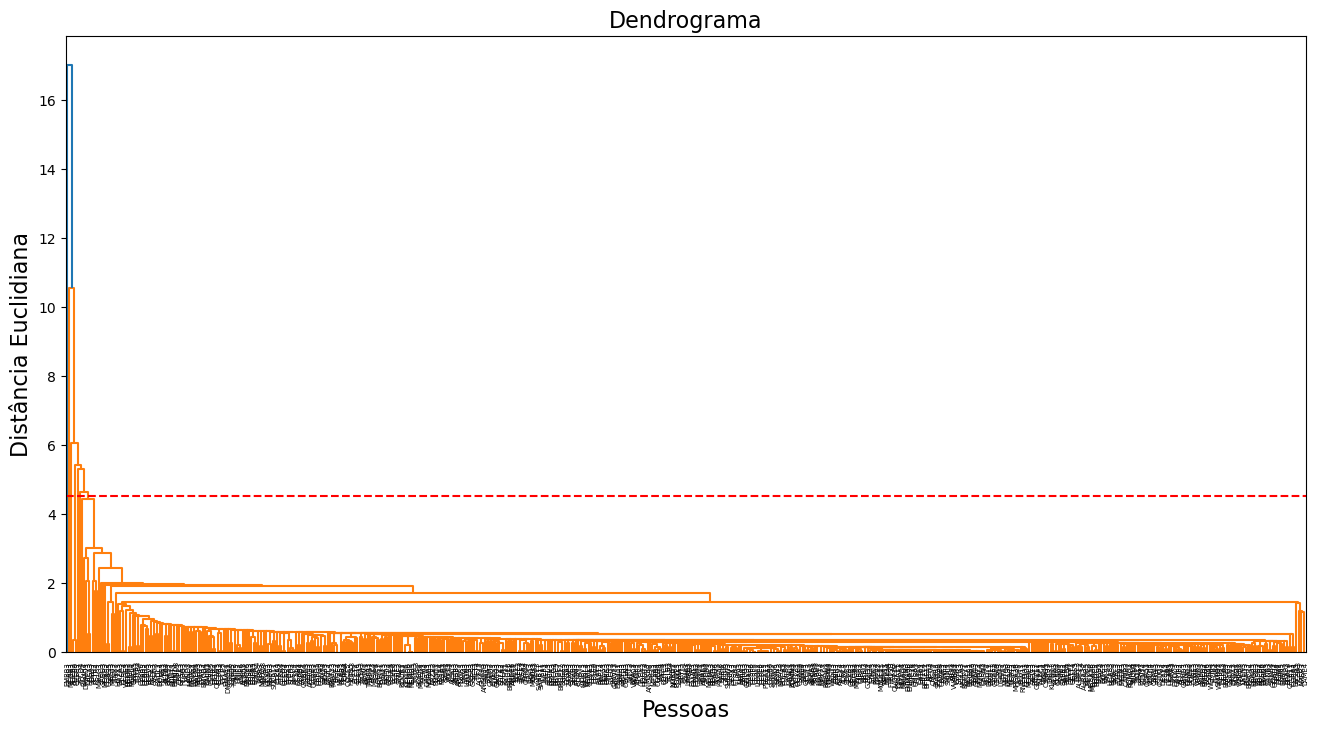

In [87]:
plt.figure(figsize=(16,8))

dendrogram = sch.dendrogram(sch.linkage(df_base, method = 'single', metric = 'euclidean'), labels = list(df_out_out.ativo))
plt.title('Dendrograma', fontsize=16)
plt.xlabel('Pessoas', fontsize=16)
plt.ylabel('Distância Euclidiana', fontsize=16)
plt.axhline(y = 4.5, color = 'red', linestyle = '--')
plt.show()


In [88]:
cluster_sing = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'single')
indica_cluster_sing = cluster_sing.fit_predict(df_base)

In [20]:
print(indica_cluster_sing, "\n")

df_out_out['cluster_single'] = indica_cluster_sing

print(df_out_out)

[0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [26]:
df_contagem = df_filtro.groupby('cluster_kmeans').size().reset_index(name='contagem')

In [27]:
x = df_filtro.loc[df_filtro['cluster_kmeans']>0]

In [28]:
x

,ativo,year,nome,CAGR LUCROS 5 ANOS,CAGR RECEITAS 5 ANOS,DY,DÍV LÍQUIDA/EBIT,DÍV LÍQUIDA/EBITDA,DÍV LÍQUIDA/PL,EV/EBIT,...,PEG RATIO,PL/ATIVOS,ROA,ROE,ROIC,VPA,cluster_single,cluster_complete,cluster_average,cluster_kmeans
0,AALR3,2022,ALLIANÇA SAÚDE E PARTICIPAÇÕES S.A.,-11.220000,0.00,0.00,0.00,-11.220000,0.00,-105.230003,...,0.00,2.69,-11.220000,0.00,0.00,8.03,0,0,0,1
1,ABCB4,2022,BANCO ABC BRASIL,5.620000,9.48,9.48,0.14,5.620000,9.48,4.940000,...,0.14,0.85,5.620000,9.48,0.14,23.15,0,0,0,1
2,ABEV3,2022,AMBEV,15.820000,5.25,5.25,1.12,15.820000,5.25,12.290000,...,1.12,2.79,15.820000,5.25,1.12,5.20,0,0,0,1
3,ADHM3,2022,ADVANCED DIGITAL HEALTH MEDICINA PREVENTIVA,-4.090000,0.00,0.00,-0.58,-4.090000,0.00,-5.690000,...,-0.58,-1.29,-4.090000,0.00,-0.58,-1.21,3,0,2,2
4,AERI3,2022,AERIS IND. E COM. DE EQUIP. GERACAO DE ENERGIA...,-9.340000,1.83,1.83,0.04,-9.340000,1.83,7.590000,...,0.04,0.98,-9.340000,1.83,0.04,1.15,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,WIZC3,2022,WIZ CO,8.320000,8.39,8.39,-0.29,8.320000,8.39,3.400000,...,-0.29,2.96,8.320000,8.39,-0.29,2.37,0,0,0,1
616,WLMM3,2022,WLM INDÚSTRIA E COMÉRCIO,6.670000,5.66,5.66,0.61,6.670000,5.66,5.440000,...,0.61,1.26,6.670000,5.66,0.61,17.08,0,0,0,1
617,WLMM4,2022,WLM INDÚSTRIA E COMÉRCIO,7.050000,3.32,3.32,0.64,7.050000,3.32,5.440000,...,0.64,1.33,7.050000,3.32,0.64,17.08,0,0,0,1
618,YDUQ3,2022,YDUQS,-53.970001,1.24,1.24,0.39,-53.970001,1.24,11.980000,...,0.39,1.07,-53.970001,1.24,0.39,9.53,0,0,0,1


In [29]:
df_contagem

,cluster_kmeans,contagem
0,0,51
1,1,558
2,2,11


In [22]:
cluster_comp = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'complete')
indica_cluster_comp = cluster_comp.fit_predict(df_drop)

print(indica_cluster_comp, "\n")

df_filtro['cluster_complete'] = indica_cluster_comp

print(df_filtro)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [23]:
cluster_avg = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'average')
indica_cluster_avg = cluster_avg.fit_predict(df_drop)

print(indica_cluster_avg, "\n")

df_filtro['cluster_average'] = indica_cluster_avg

print(df_filtro)

[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

Cluster Hierárquico Aglomerativo com encadeamentos single,complete e average ... nao tivemos bons resultados. Possiveis motivos: Muitas colunas discrepantes, outliers.

tentando com k-means

In [177]:
kmeans = KMeans(n_clusters = 15, init = 'random').fit(ddf)

In [179]:
kmeans_clusters = kmeans.labels_

print(kmeans_clusters)

ddf['cluster_kmeans'] = kmeans_clusters

print(ddf)

[10  5  5  0  0 10 10  3 10  6  0  6  3 10 10  0 10 10  5  5  5  0 10  1
 10  0  0  0  0  0 10 10 10  0 10  5  0  0  0  0  0 10 10  2  2  7  3  3
  5  5  0 10  0  0  0 14  3  5  0  0  5  5  0  0  0 10 10  0  0  5  5  3
  0  5 10  5  5  0  0 10 10  5  5 11  0  0  3  3  3  0  0  0  5  0  0  0
  5  0  5  0  0  0  5 12 12 12  0  0  0  5  5  5  6  5  5  0  8  0  5  0
  5  0  0  0  0  0  5 12  5  0  9  2  2  2  0  0  3  2  0  0  0  0  0  0
  0  0  0  0 14 14  3  3  5  0  5  5  5  3  2  0  0  0  0  5  0  0  3  3
  3 10  3  0 10 10  0  5  0  3  3  5 10 10  1  0  3  3  2  0  5  0  0  0
  0  0  0  0  0 10 10  5  5  0  0  5  5  5 12  7  0  0  1  0  7  0  5  3
  3  0  0  0 11 11  5  2  2 10 10 10  0  5 10  0  0 10 13  3  3 10 10 10
  5  0  0  0 10 10  2  5 10  0 10 10  0  4  4  5  0  0  5  5  0  0  5  3
  0 10  0  0  0 10  0  5  0  5  0  0  0  0  0  5  5  5  5  5  0  3  3 10
 10 10  3  3  0  2  0  0  5  4 10  0  0  0 12  5  0  7  5  4  4  1  0  0
 10  0  0  0  4  0  0 10  9 10  0  0  0 10  0 14  5

C:\Users\Danimay\AppData\Local\Temp\ipykernel_24176\2990186318.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [183]:
df_analise = ddf.loc[ddf['cluster_kmeans']==13]

In [184]:
df_analise

,DY,P/L,EV/EBITDA,M EBITDA,ROE,P/VP,VPA,cluster_kmeans
237,-0.540632,-0.332053,-23.27574,-0.332053,-0.540632,-0.096447,0.13191,13


In [182]:
ddf.groupby('cluster_kmeans').count()

,DY,P/L,EV/EBITDA,M EBITDA,ROE,P/VP,VPA
cluster_kmeans,,,,,,,
0,255,255,255,255,255,255,255
1,8,8,8,8,8,8,8
2,15,15,15,15,15,15,15
3,48,48,48,48,48,48,48
4,6,6,6,6,6,6,6
5,133,133,133,133,133,133,133
6,4,4,4,4,4,4,4
7,5,5,5,5,5,5,5
8,3,3,3,3,3,3,3


In [ ]:
cent_finais = pd.DataFrame(kmeans.cluster_centers_)
cent_finais.columns = df_out_out.columns
cent_finais.index.name = 'cluster'
print(cent_finais)

c:\Users\jeffr\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


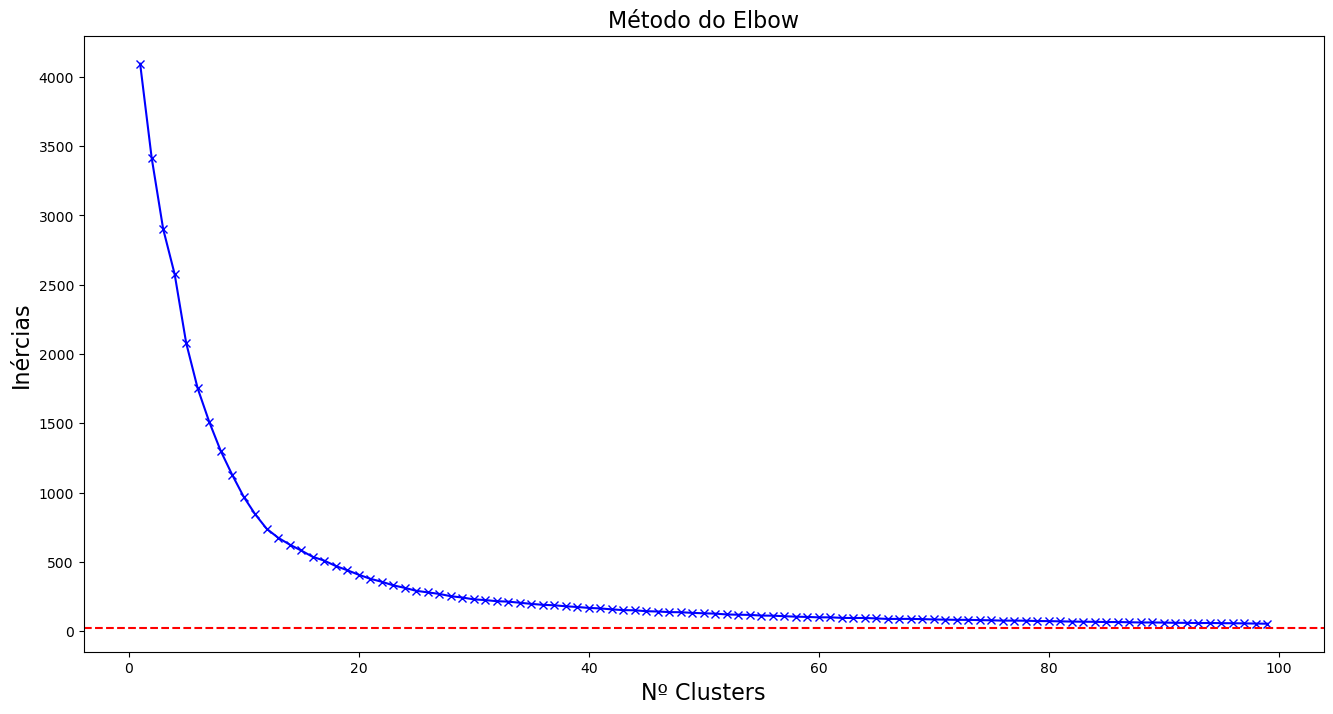

In [153]:
inercias = []
K = range(1,100)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(df_base)
    inercias.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, inercias, 'bx-')
plt.axhline(y = 20, color = 'red', linestyle = '--')
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Inércias', fontsize=16)
plt.title('Método do Elbow', fontsize=16)
plt.show()

In [154]:
def teste_f_kmeans(kmeans, dataframe):
    
    variaveis = dataframe.columns

    centroides = pd.DataFrame(kmeans.cluster_centers_)
    centroides.columns = dataframe.columns
    centroides
    
    print("Centróides: \n", centroides ,"\n")

    df = dataframe[variaveis]

    unique, counts = np.unique(kmeans.labels_, return_counts=True)

    dic = dict(zip(unique, counts))

    qnt_clusters = kmeans.n_clusters

    observacoes = len(kmeans.labels_)

    df['cluster'] = kmeans.labels_

    output = []

    for variavel in variaveis:

        dic_var={'variavel':variavel}

        # variabilidade entre os grupos

        variabilidade_entre_grupos = np.sum([dic[index]*np.square(observacao - df[variavel].mean()) for index, observacao in enumerate(centroides[variavel])])/(qnt_clusters - 1)

        dic_var['variabilidade_entre_grupos'] = variabilidade_entre_grupos

        variabilidade_dentro_dos_grupos = 0

        for grupo in unique:

            grupo = df[df.cluster == grupo]

            variabilidade_dentro_dos_grupos += np.sum([np.square(observacao - grupo[variavel].mean()) for observacao in grupo[variavel]])/(observacoes - qnt_clusters)

        dic_var['variabilidade_dentro_dos_grupos'] = variabilidade_dentro_dos_grupos

        dic_var['F'] =  dic_var['variabilidade_entre_grupos']/dic_var['variabilidade_dentro_dos_grupos']
        
        dic_var['sig F'] =  1 - stats.f.cdf(dic_var['F'], qnt_clusters - 1, observacoes - qnt_clusters)

        output.append(dic_var)

    df = pd.DataFrame(output)
    
    print(df)

    return df

In [155]:
output = teste_f_kmeans(kmeans,df_base)

Centróides: 
           DY        P/L  EV/EBITDA   M EBITDA       ROE      P/VP       VPA
0  -0.387182  -0.124007   0.027118  -0.124007 -0.387182 -0.159138  2.600255
1   7.349404  -0.076573  -0.037441  -0.076573  7.349404 -0.052187  0.456742
2  -0.554660  -0.230779   0.013967  -0.230779 -0.554660 -1.069427 -1.896199
3  -0.554660  -5.641143   0.275215  -5.641143 -0.554660 -0.035682 -0.383972
4  -0.544543  -0.203765  -0.072872  -0.203765 -0.544543 -0.248024 -0.515644
5   0.670931  -0.034709   0.047706  -0.034709  0.670931  0.045773 -0.033022
6  -0.206090   2.613185   0.510943   2.613185 -0.206090  0.020606 -0.105511
7  -0.554660  -0.082625  -0.016973  -0.082625 -0.554660 -9.558050 -0.755170
8   0.839417  -0.009421  -0.014916  -0.009421  0.839417 -0.049073  2.306005
9  -0.229193   0.241485   0.182990   0.241485 -0.229193  0.425072 -0.302126
10  2.475071   0.008932   0.010390   0.008932  2.475071  0.151037  0.217801
11 -0.347605  -0.021918   0.009251  -0.021918 -0.347605 -0.138980  0.58248

In [156]:
import plotly.express as px 
import plotly.io as pio

pio.renderers.default='browser'

fig = px.scatter_3d(df_out_out, 
                    x='DY', 
                    y='P/L', 
                    z='EV/EBITDA',
                    color='cluster_kmeans')
fig.show()

               DY        P/L  EV/EBITDA   M EBITDA       ROE      P/VP  \
cluster                                                                  
0       -0.387182  -0.124007   0.027118  -0.124007 -0.387182 -0.159138   
1        7.349404  -0.076573  -0.037441  -0.076573  7.349404 -0.052187   
2       -0.554660  -0.230779   0.013967  -0.230779 -0.554660 -1.069427   
3       -0.554660  -5.641143   0.275215  -5.641143 -0.554660 -0.035682   
4       -0.544543  -0.203765  -0.072872  -0.203765 -0.544543 -0.248024   
5        0.670931  -0.034709   0.047706  -0.034709  0.670931  0.045773   
6       -0.206090   2.613185   0.510943   2.613185 -0.206090  0.020606   
7       -0.554660  -0.082625  -0.016973  -0.082625 -0.554660 -9.558050   
8        0.839417  -0.009421  -0.014916  -0.009421  0.839417 -0.049073   
9       -0.229193   0.241485   0.182990   0.241485 -0.229193  0.425072   
10       2.475071   0.008932   0.010390   0.008932  2.475071  0.151037   
11      -0.347605  -0.021918   0.00925

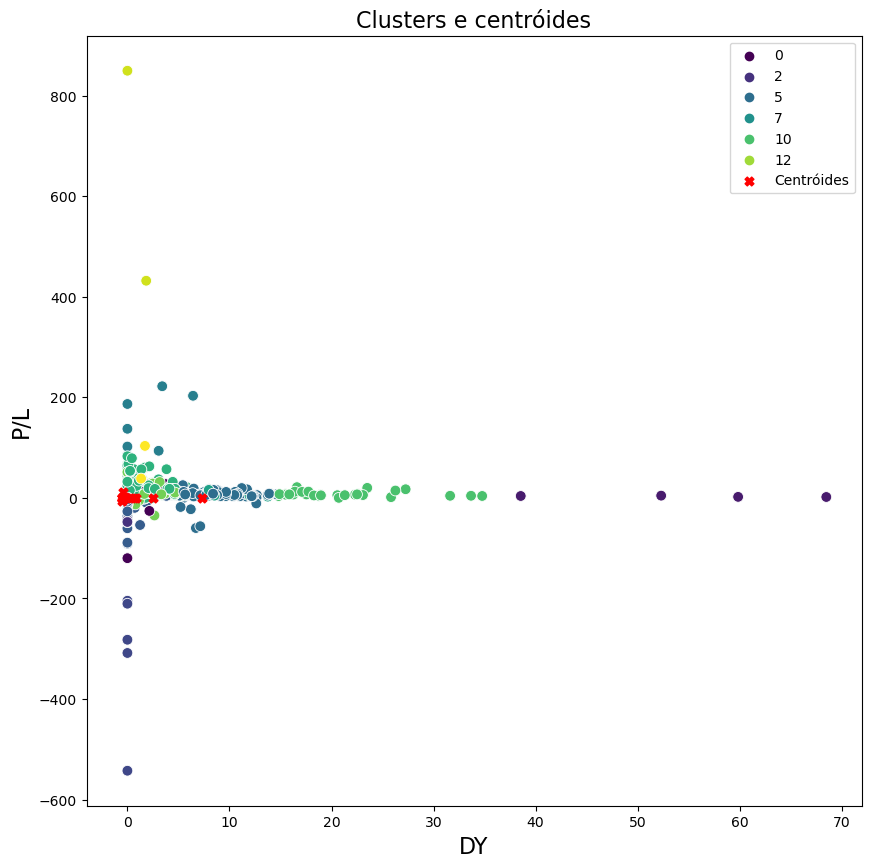

In [157]:
cent_finais = pd.DataFrame(kmeans.cluster_centers_)
cent_finais.columns = df_base.columns
cent_finais.index.name = 'cluster'
print(cent_finais)

#%% Plotando as observações e seus centróides dos clusters

plt.figure(figsize=(10,10))

pred_y = kmeans.fit_predict(df_base)
sns.scatterplot(x='DY', y='P/L', data=df_out_out, hue='cluster_kmeans', palette='viridis', s=60)
plt.scatter(cent_finais['DY'], cent_finais['P/L'], s = 40, c = 'red', label = 'Centróides', marker="X")
plt.title('Clusters e centróides', fontsize=16)
plt.xlabel('DY', fontsize=16)
plt.ylabel('P/L', fontsize=16)
plt.legend()
plt.show()